In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import geopandas as gpd

import common_utils

In [2]:
# Bounds and parameters
lower_bound = 283.15  # Temperature in Kelvin (e.g., 0°C in Kelvin)
upper_bound = 323.15  # Temperature in Kelvin (e.g., 50°C in Kelvin)
no_data_percent = 0.20  # No data threshold
sample_size = 2000  # Number of random rows to sample

In [3]:

# Read data
file_path = '../msg_lu_fused_data_for_glm/concatenated_data.gpkg'
gdf =  gpd.read_file(file_path)  # Read the .gpkg file

# Define target and LULC columns
target = 'temperature'  # Replace with your target column name

# Convert to Kelvin
gdf['temperature'] = gdf['temperature'] + 273.15

# Ensure categorical variables are treated as such
gdf['hour'] = gdf['hour'].astype('category')
gdf['month'] = gdf['month'].astype('category')

# Drop the geometry column
gdf = gdf.drop(columns=['geometry'])

# Define LULC columns (all columns except the target)
lulc_columns = ['water', 'trees', 'crop', 'built_area', 'bare_ground', 'range_land']

# Drop rows with missing values
gdf = gdf.dropna(subset=[target, 'hour', 'month'] + lulc_columns)

# Drops rows with no_data > no_data_percent
gdf = gdf[gdf['no_data'] <= no_data_percent]
data = gdf

# 1. Prepare the data
X = data[['month', 'hour', 'water', 'trees', 'crop', 'built_area', 'bare_ground', 'range_land']]
y = data['temperature']

# One-hot encode categorical variables (month, hour)
X = pd.get_dummies(X, columns=['month', 'hour'], drop_first=True)

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# 3. Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 4. Train the model
rf_model.fit(X_train, y_train)

# 5. Make predictions
y_pred = rf_model.predict(X_test)

In [4]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# 6. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("Root Mean Squared Error:", round(rmse, 1))


Root Mean Squared Error: 3.1


In [5]:

# 7. Feature importance (optional)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("Feature Importances:\n", feature_importances.sort_values(ascending=False))


Feature Importances:
 hour_13        0.109714
hour_11        0.109428
hour_12        0.108057
hour_14        0.098079
hour_10        0.096416
hour_9         0.080664
hour_15        0.080633
hour_16        0.056007
hour_8         0.054776
month_7        0.036593
month_8        0.033770
hour_7         0.029599
hour_17        0.029512
crop           0.018326
trees          0.011375
hour_18        0.011296
hour_6         0.008831
hour_19        0.004881
range_land     0.003850
bare_ground    0.003836
water          0.003580
built_area     0.003415
hour_20        0.002562
hour_21        0.001398
hour_5         0.001085
hour_22        0.000879
hour_23        0.000372
hour_3         0.000305
hour_2         0.000267
hour_4         0.000256
hour_1         0.000237
dtype: float64


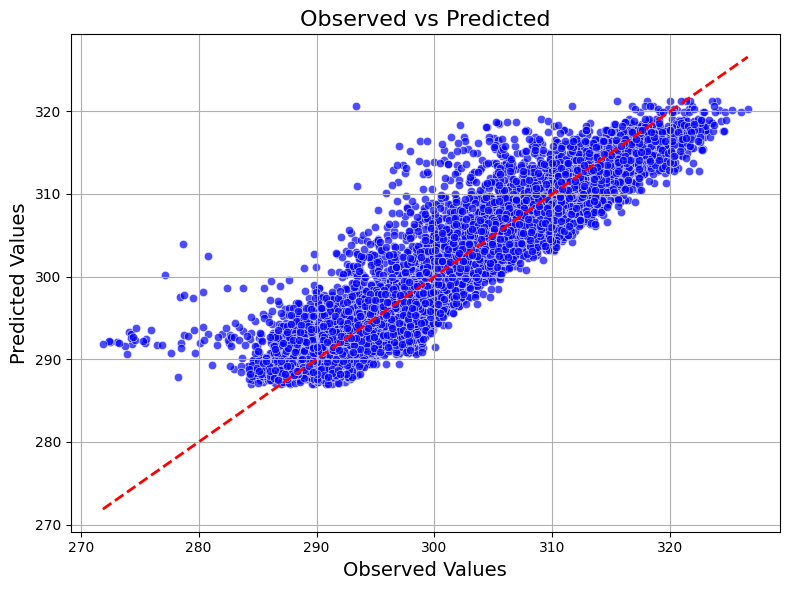

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y_test' contains observed values and 'y_pred' contains predicted values

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color='blue')

# Add a diagonal line for reference (perfect prediction line)
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

# Customize the plot
plt.title("Observed vs Predicted", fontsize=16)
plt.xlabel("Observed Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


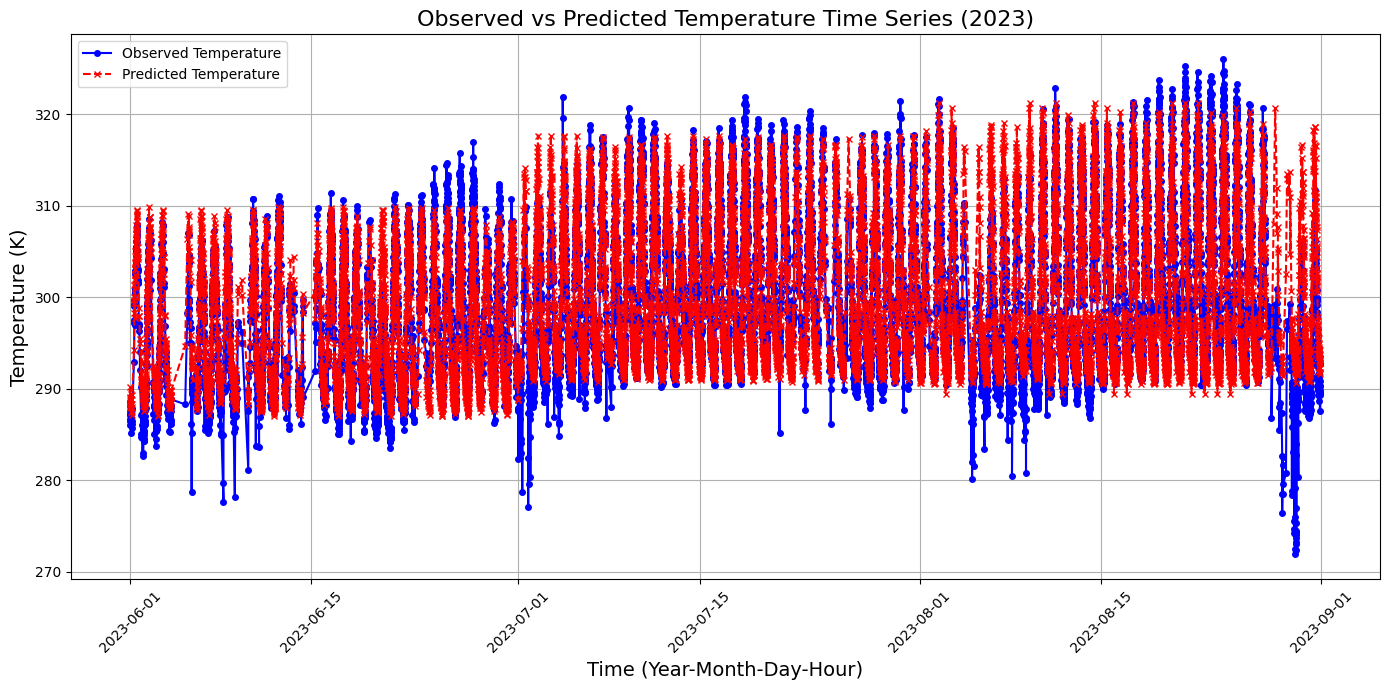

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' has the original 'year', 'month', 'day', 'hour', and 'temperature' columns
# Recreate the 'date_time' column using the original 'year', 'month', 'day', and 'hour' columns
test_data = X_test.copy()

# Retrieve 'year', 'month', 'day', 'hour' from the original data
test_data['year'] = data.loc[X_test.index, 'year']
test_data['month'] = data.loc[X_test.index, 'month']
test_data['day'] = data.loc[X_test.index, 'day']
test_data['hour'] = data.loc[X_test.index, 'hour']

# Create 'date_time' column by combining 'year', 'month', 'day', and 'hour'
test_data['date_time'] = pd.to_datetime(test_data[['year', 'month', 'day', 'hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')

# Filter for the year 2023
test_data_2023 = test_data[test_data['year'] == 2023]

# Sort the data by 'date_time'
test_data_sorted_2023 = test_data_2023.sort_values(by='date_time')

# Use the sorted index of 'test_data_sorted_2023' to match 'y_test'
y_test_sorted_2023 = y_test.loc[test_data_sorted_2023.index]

# Use the sorted index to match the predictions to the sorted data
y_pred_sorted_2023 = rf_model.predict(X_test.loc[test_data_sorted_2023.index])

# Plotting observed vs predicted temperatures for the year 2023
plt.figure(figsize=(14, 7))
plt.plot(test_data_sorted_2023['date_time'], y_test_sorted_2023, label='Observed Temperature', color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(test_data_sorted_2023['date_time'], y_pred_sorted_2023, label='Predicted Temperature', color='red', linestyle='--', marker='x', markersize=4)

# Customize the plot
plt.title("Observed vs Predicted Temperature Time Series (2023)", fontsize=16)
plt.xlabel("Time (Year-Month-Day-Hour)", fontsize=14)
plt.ylabel("Temperature (K)", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


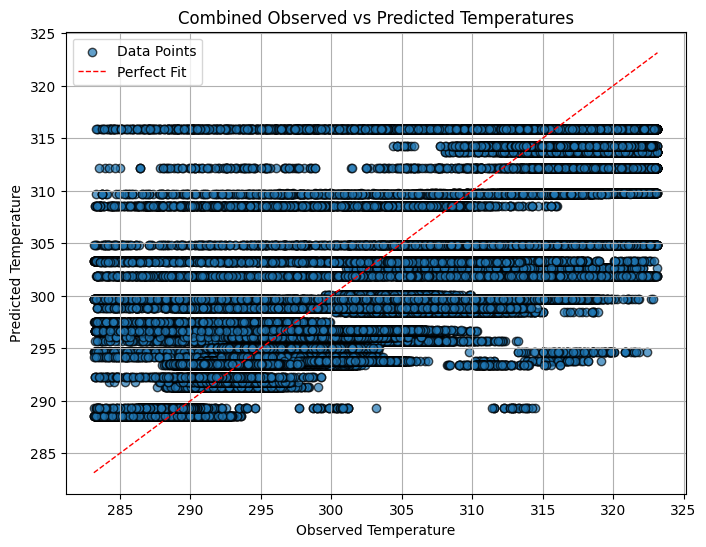

Root Mean Squared Error (RMSE): 7.46
RMSLE: 0.02443313555007254


In [8]:
import os
import geopandas as gpd
import patsy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import common_utils

# Directory containing the Ecostress files
ecostress_dir = "../ecostress_lulc_temprature_datetime_fused/"
file_extension = ".gpkg"

# Land use columns and target column
land_use_columns = ['water', 'trees', 'flooded_veg', 'crop', 'built_area', 'bare_ground', 'snow_or_ice', 'clouds', 'range_land']
columns_to_check = land_use_columns + ['no_data']
target = 'temperature'

# Placeholder for RMSE calculation and combined plotting
all_observed = []
all_predicted = []

# Load the trained Random Forest model (assuming it has been trained already)
# If the model is saved to a file, you can load it like this:
# rf_model = joblib.load('path_to_trained_rf_model.pkl')

# Iterate over all Ecostress files
for file_name in os.listdir(ecostress_dir):
    if file_name.endswith(file_extension):
        ecostress_file = os.path.join(ecostress_dir, file_name)

        # Read the file
        new_gdf = gpd.read_file(ecostress_file)

        # Filter for summer months
        new_gdf = new_gdf[new_gdf['month'].isin([6, 7, 8])]

        # Filter rows based on land use and no_data columns
        new_gdf = new_gdf[~(new_gdf[columns_to_check] == 0).all(axis=1)]
        new_gdf = new_gdf[new_gdf['no_data'] <= no_data_percent]

        # Convert temperature to Kelvin
        new_gdf['temperature'] = new_gdf['temperature'] + 273.15

        # Filter out rows outside this range
        new_gdf = new_gdf[(new_gdf[target] >= lower_bound) & (new_gdf[target] <= upper_bound)]

        # Ensure categorical variables
        new_gdf['hour'] = new_gdf['hour'].astype('category')
        new_gdf['month'] = new_gdf['month'].astype('category')

        # Ensure consistent categories
        new_gdf['month'] = pd.Categorical(new_gdf['month'], categories=gdf['month'].unique())
        new_gdf['hour'] = pd.Categorical(new_gdf['hour'], categories=gdf['hour'].unique())

        # Drop rows with missing values
        new_gdf = new_gdf.dropna(subset=['temperature', 'hour', 'month'])

        # Randomly sample 2000 rows
        if len(new_gdf) > sample_size:
            new_gdf = new_gdf.sample(n=sample_size)

        if new_gdf.shape[0] == 0:
            continue

        # Prepare the input features for prediction
        X_new = new_gdf[['hour', 'month']]

        # One-hot encode categorical features (month and hour)
        X_new_encoded = pd.get_dummies(X_new, columns=['month', 'hour'], drop_first=True)

        # Add missing columns with default values (zero) if necessary
        missing_columns = set(X_train.columns) - set(X_new_encoded.columns)
        for col in missing_columns:
            X_new_encoded[col] = 0

        # Ensure the column order matches the training data
        X_new_encoded = X_new_encoded[X_train.columns]

        # Use the trained Random Forest model to predict temperature
        new_gdf['predicted'] = rf_model.predict(X_new_encoded)

        # Store observed and predicted values for combined plot
        all_observed.extend(new_gdf['temperature'].tolist())
        all_predicted.extend(new_gdf['predicted'].tolist())

# Plot all observed vs. predicted values in one plot
plt.figure(figsize=(8, 6))
plt.scatter(all_observed, all_predicted, alpha=0.7, edgecolor='k', label='Data Points')

min_val = lower_bound
max_val = upper_bound

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1, label='Perfect Fit')

# Add labels, title, and legend
plt.xlabel('Observed Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Combined Observed vs Predicted Temperatures')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Calculate RMSE for the combined observed and predicted data
rmse = np.sqrt(mean_squared_error(all_observed, all_predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

rmsle_value = common_utils.calculate_rmsle(all_observed, all_predicted)
print(f"RMSLE: {rmsle_value}")